## Basic Data Load Steps

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [ ]:
# only of running on Google Colab
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [17]:
def load_data(data_dir, image_size=(64, 64)):
    """
    Load GEI images from the specified directory.

    Args:
        data_dir (str): Path to the data directory.
        image_size (tuple): Size to resize images (default is 64x64).

    Returns:
        dict: Dictionary with class names as keys and list of images as values.
    """
    data = {}
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            images = []
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                image = Image.open(image_path).convert('L').resize(image_size)
                images.append(np.array(image) / 255.0)  # Normalize pixel values
            data[class_name] = np.array(images)
    return data

data_dir = "D:\\Artificial Intelligence\\Machine Learning\\PhD - Advanced Machine Learning\\GEI Project\\Dataset_fewshot"  # Replace with your path
image_size = (64, 64)
data = load_data(data_dir, image_size)


In [18]:
def split_support_query(data, support_size=5):
    """
    Split each class's data into support and query sets.

    Args:
        data (dict): Dictionary containing images for each class.
        support_size (int): Number of samples per class for the support set.

    Returns:
        dict, dict: Support set and query set dictionaries.
    """
    support_set = {}
    query_set = {}
    for class_name, images in data.items():
        support, query = train_test_split(images, train_size=support_size, random_state=42)
        support_set[class_name] = support
        query_set[class_name] = query
    return support_set, query_set

support_size = 5
support_set, query_set = split_support_query(data, support_size)


## Prototypical Network Details

In [19]:
def compute_prototypes(support_set):
    """
    Compute class prototypes (mean of support images).

    Args:
        support_set (dict): Support set with images for each class.

    Returns:
        dict: Prototypes for each class.
    """
    prototypes = {}
    for class_name, images in support_set.items():
        prototypes[class_name] = np.mean(images, axis=0)
    return prototypes

prototypes = compute_prototypes(support_set)


In [20]:
def classify_query(query_set, prototypes):
    """
    Classify query samples using Euclidean distance to prototypes.

    Args:
        query_set (dict): Query set with images for each class.
        prototypes (dict): Class prototypes.

    Returns:
        list, list: Predicted labels and true labels for the query set.
    """
    predictions = []
    true_labels = []
    class_names = list(prototypes.keys())

    for class_name, images in query_set.items():
        for image in images:
            distances = [np.linalg.norm(image - prototypes[proto_class]) for proto_class in class_names]
            predicted_class = class_names[np.argmin(distances)]
            predictions.append(predicted_class)
            true_labels.append(class_name)
    return predictions, true_labels

predictions, true_labels = classify_query(query_set, prototypes)


In [21]:
accuracy = accuracy_score(true_labels, predictions)
print(f"Classification Accuracy: {accuracy * 100:.2f}%")


Classification Accuracy: 73.14%


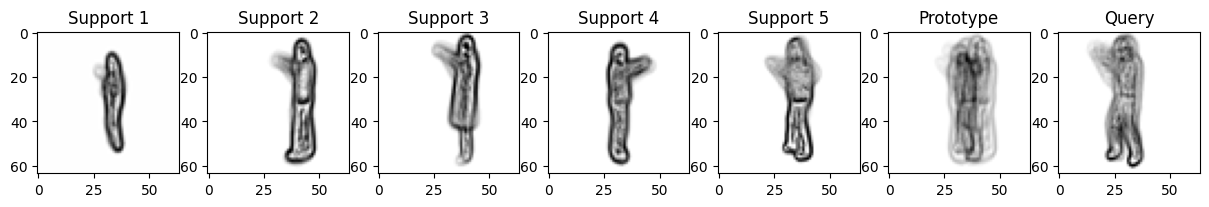

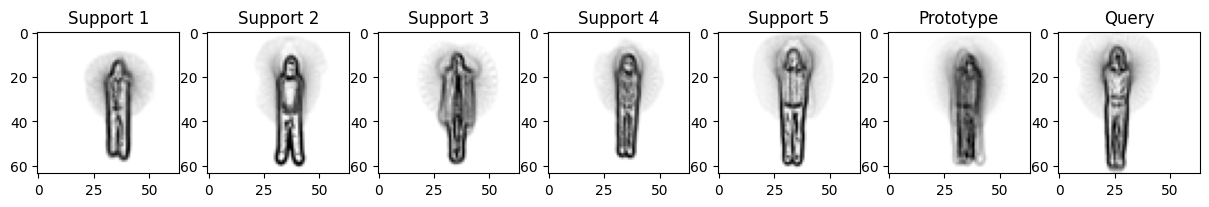

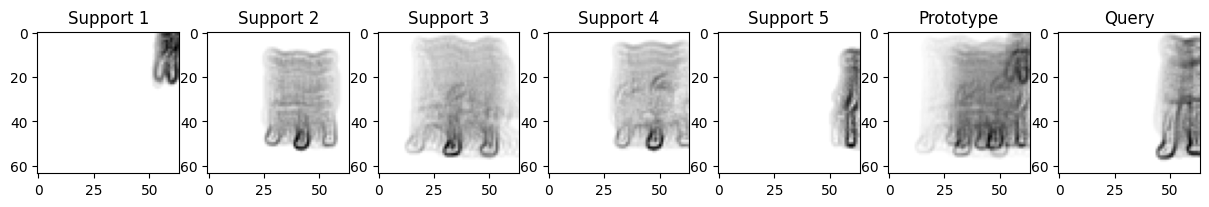

In [22]:
def plot_samples(prototypes, support_set, query_set):
    """
    Visualize support images, prototypes, and query samples.
    """
    class_names = prototypes.keys()
    for class_name in class_names:
        fig, axes = plt.subplots(1, len(support_set[class_name]) + 2, figsize=(15, 5))
        for i, img in enumerate(support_set[class_name]):
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f"Support {i+1}")
        axes[len(support_set[class_name])].imshow(prototypes[class_name], cmap='gray')
        axes[len(support_set[class_name])].set_title("Prototype")
        for i, img in enumerate(query_set[class_name][:1]):  # Show 1 query for simplicity
            axes[len(support_set[class_name]) + 1 + i].imshow(img, cmap='gray')
            axes[len(support_set[class_name]) + 1 + i].set_title(f"Query")
        plt.show()

plot_samples(prototypes, support_set, query_set)
